**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

**Edición 2024**

---

### **Introducción al Aprendizaje Profundo 2024**
### Redes Convolucionales

---

# CNN para clasificación de imágenes con Pytorch

- Veremos cómo construir una CNN para clasificar imágenes en MNIST.

- También tocaremos un poco cómo trabajar con modelos preentrenados (Tranfer Learning) como el modelo de [ResNet](https://pytorch.org/vision/stable/models.html#resnet).

In [1]:
# Importando líbrerias
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import torch
from torch.utils.data import TensorDataset, DataLoader, SubsetRandomSampler, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor, transforms

seed = 28
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [5]:
def data_preparation(BATCH_SIZE, transform):
    # Cargar los datos de entrenamiento desde la carpeta
    train_set = torchvision.datasets.ImageFolder(root='../Data/butterflies_moths_dataset/train', transform=transform)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

    # Cargar los datos de validación (si lo tienes)
    val_set = torchvision.datasets.ImageFolder(root='../Data/butterflies_moths_dataset/valid', transform=transform)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    # Cargar los datos de prueba
    test_set = torchvision.datasets.ImageFolder(root='../Data/butterflies_moths_dataset/test', transform=transform)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    return train_set, train_loader, val_set, val_loader, test_set, test_loader

In [8]:
BATCH_SIZE = 64

# Definir las transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Redimensionar las imágenes al tamaño 224x224
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalizar las imágenes
])

# Preparar los datasets y loaders
train_set, train_loader, val_set, val_loader, test_set, test_loader = data_preparation(BATCH_SIZE, transform)

# Obtener las clases (carpetas de especies)
classes = train_set.classes
print(f'Classes: {classes}')

Classes: ['ADONIS', 'AFRICAN GIANT SWALLOWTAIL', 'AMERICAN SNOOT', 'AN 88', 'APPOLLO', 'ARCIGERA FLOWER MOTH', 'ATALA', 'ATLAS MOTH', 'BANDED ORANGE HELICONIAN', 'BANDED PEACOCK', 'BANDED TIGER MOTH', 'BECKERS WHITE', 'BIRD CHERRY ERMINE MOTH', 'BLACK HAIRSTREAK', 'BLUE MORPHO', 'BLUE SPOTTED CROW', 'BROOKES BIRDWING', 'BROWN ARGUS', 'BROWN SIPROETA', 'CABBAGE WHITE', 'CAIRNS BIRDWING', 'CHALK HILL BLUE', 'CHECQUERED SKIPPER', 'CHESTNUT', 'CINNABAR MOTH', 'CLEARWING MOTH', 'CLEOPATRA', 'CLODIUS PARNASSIAN', 'CLOUDED SULPHUR', 'COMET MOTH', 'COMMON BANDED AWL', 'COMMON WOOD-NYMPH', 'COPPER TAIL', 'CRECENT', 'CRIMSON PATCH', 'DANAID EGGFLY', 'EASTERN COMA', 'EASTERN DAPPLE WHITE', 'EASTERN PINE ELFIN', 'ELBOWED PIERROT', 'EMPEROR GUM MOTH', 'GARDEN TIGER MOTH', 'GIANT LEOPARD MOTH', 'GLITTERING SAPPHIRE', 'GOLD BANDED', 'GREAT EGGFLY', 'GREAT JAY', 'GREEN CELLED CATTLEHEART', 'GREEN HAIRSTREAK', 'GREY HAIRSTREAK', 'HERCULES MOTH', 'HUMMING BIRD HAWK MOTH', 'INDRA SWALLOW', 'IO MOTH', 'Ip

In [ ]:
for images, _ in trainloader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [9]:
len(train_loader), len(val_loader)

(197, 8)

In [11]:
train_loader.batch_size, val_loader.batch_size

(64, 64)

In [36]:
def train_val(model, criterion, optimizer, train_loader, val_loader, num_epochs):
    # Ciclo for para el número de épocas
    train_loss_history, train_acc_history, val_loss_history, val_acc_history = [], [], [], []
    all_labels, all_preds = [], []
    model = model.to(device=device)
    for epoch in range(num_epochs):
        train_loss, train_acc, val_loss, val_acc = 0, 0, 0, 0

        # Establecer el modelo en modo de entrenamiento
        model.train()
        y_true_train, y_pred_train = [], []
        # Iterar sobre los datos de entrenamiento
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.long)
            optimizer.zero_grad()
            predicted_outputs = model(inputs)
            # Calcular la pérdida
            loss = criterion(predicted_outputs, labels)
            loss.backward()
            optimizer.step()
            # Acumular la pérdida y la precisión
            train_loss += loss.item()
            # La etiqueta con mayor valor será nuestra predicción
            _, predicted = torch.max(predicted_outputs , 1)
            y_true_train.extend(labels.cpu().numpy())
            y_pred_train.extend(predicted.cpu().numpy())

        # Calcular la pérdida y precisión promedio del entrenamiento
        train_loss /= len(train_loader)
        train_loss_history.append(train_loss)
        train_acc = accuracy_score(y_true_train, y_pred_train)
        train_acc_history.append(train_acc)

        # set the model to evaluation mode
        model.eval()
        y_true_test, y_pred_test = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.long)
                # Run the forward pass
                predicted_outputs = model(inputs)
                # Compute loss
                loss = criterion(predicted_outputs, labels)
                # Accumulate the average loss of the mini-batch
                val_loss += loss.item()
                # The label with the highest value will be our prediction
                _, predicted = torch.max(predicted_outputs , 1)
                y_true_test.extend(labels.cpu().numpy())
                y_pred_test.extend(predicted.cpu().numpy())

        # calculate the average validation loss and accuracy
        val_loss /= len(val_loader)
        val_loss_history.append(val_loss)
        val_acc = accuracy_score(y_true_test, y_pred_test)
        val_acc_history.append(val_acc)
        all_labels.extend(y_true_test)
        all_preds.extend(y_pred_test)

        print(f'Epoch {epoch+1}/{num_epochs}, train loss: {train_loss:.4f}, train acc: {train_acc:.4f}, val loss: {val_loss:.4f}, val acc: {val_acc:.4f}')

    experiment = {
        'epoch_training_loss': train_loss_history,
        'training_accuracy': train_acc_history,
        'epoch_validation_loss': val_loss_history,
        'validation_accuracy': val_acc_history
    }
    experiment['epoch'] = list(range(num_epochs))

    return experiment, all_labels, all_preds


def plotting_confusion_matrix(all_labels, all_preds, title_name=''):

    # Plotting Confusion Matrix
    fig, axs = plt.subplots(1, 2, figsize = (14, 6))

    # Implementing visualization of Confusion Matrix
    c_m = confusion_matrix(all_labels, all_preds)
    c_m_normalized = confusion_matrix(all_labels, all_preds, normalize='true').round(3)

    ConfusionMatrixDisplay(c_m, display_labels=classes).plot(cmap='Greys', xticks_rotation=25, ax=axs[0])
    ConfusionMatrixDisplay(c_m_normalized*100, display_labels=classes).plot(cmap='Greys', xticks_rotation=25, ax=axs[1],)

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    axs[0].set_title('Valores absolutos', fontsize=14)
    axs[1].set_title('Valores porcentuales', fontsize=14)
    plt.suptitle(f'Confusion Matrix {title_name}', fontsize=16)
    plt.show()


def plot_loss_and_accuracy(train_loss_history, val_loss_history, train_acc_history, val_acc_history):
    fig, axs = plt.subplots(1, 2, figsize = (10, 4))

    # Plot the training and validation loss
    axs[0].plot(train_loss_history, label='train loss')
    axs[0].plot(val_loss_history, label='val loss')
    axs[0].grid()

    # Plot the training and validation accuracy
    axs[1].plot(train_acc_history, label='train acc')
    axs[1].plot(val_acc_history, label='val acc')
    axs[1].grid()
    plt.legend()
    plt.show()

import pandas as pd
import seaborn as sns

def plot_loss_and_accuracy(experiment, title=None):
  df_experiment = pd.DataFrame(experiment)

  fig, axs = plt.subplots(1, 2, figsize=(15, 4))
  sns.lineplot(data=df_experiment, x='epoch', y='epoch_training_loss', color='orange',
                  label='Training', markersize=10, lw=1.5, marker='*', ax=axs[0])
  sns.lineplot(data=df_experiment, x='epoch', y='epoch_validation_loss',
                  label='Validation', markersize=10, linestyle='--', lw=1.5, marker='.', ax=axs[0])
  plt.grid('--')
  sns.lineplot(data=df_experiment, x='epoch', y='training_accuracy', color='orange',
                  label='Training', markersize=10, lw=1.5, marker='*', ax=axs[1])
  sns.lineplot(data=df_experiment, x='epoch', y='validation_accuracy',
                  label='Validation', markersize=10, linestyle='--', lw=1.5, marker='.', ax=axs[1])
  for i, ax in enumerate(axs.ravel()):
      print(i)
      ax.set_xlabel('Epoch')
      if i < 1:
        ax.set_ylabel('Loss')
      else:
        ax.set_ylabel('Accuracy')
      ax.legend()
      ax.grid('--')
      ax.spines["top"].set_visible(False)
      ax.spines["right"].set_visible(False)
  plt.suptitle(title)
  plt.xticks(rotation=40, fontsize=8)
  plt.yticks(fontsize=9)
  plt.show()

## Modelo de clasificación con Capas Fully Connected

In [15]:
# Define the class Net
class Net(nn.Module):
    def __init__(self, num_classes=100):
    	# Define all the parameters of the net
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28 * 3, 20)
        self.fc2 = nn.Linear(20, num_classes)

    def forward(self, x):
    	# Do the forward pass
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [16]:
# Instantiate the Adam optimizer and Cross-Entropy loss function
model = Net()
optimizer = optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()

for batch_idx, (data, target) in enumerate(train_loader):
    data = data.view(-1, 28 * 28)
    optimizer.zero_grad()
    # Complete a forward pass
    output = model(data)
    # Compute the loss, gradients and change the weights
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()

# Set the model in eval mode
model.eval()
total, correct = (0, 0)
all_labels, all_preds = [], []
for i, data in enumerate(val_loader, 0):
    inputs, labels = data
    all_labels.extend(list(labels.numpy()))

    # Put each image into a vector
    inputs = inputs.view(-1, 28*28*1)

    # Do the forward pass and get the predictions
    outputs = model(inputs)
    _, outputs = torch.max(outputs.data, 1)
    all_preds.extend(list(outputs.numpy()))
    total += labels.size(0)
    correct += (outputs == labels).sum().item()
print('The testing set accuracy of the network is: %d %%' % (100 * correct / total))

ValueError: Expected input batch_size (192) to match target batch_size (64).

In [17]:
plotting_confusion_matrix(all_labels, all_preds, title_name='- Fully Connected NN')

NameError: name 'all_labels' is not defined

## Arquitecturas Bases

In [25]:
class NetCNN(nn.Module):
    def __init__(self):
        super(NetCNN, self).__init__()
        # Instantiate two convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=5, out_channels=10, kernel_size=3, padding=1)
        # Instantiate the ReLU nonlinearity
        self.relu = nn.ReLU()
        # Instantiate a max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # Instantiate a fully connected layer
        self.fc = nn.Linear(7 * 7 * 10, 100)


    def forward(self, x):
        # Apply conv followd by relu, then in next line pool
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        # Apply conv followed by relu, then in next line pool
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        # Prepare the image for the fully connected layer
        x = x.view(-1, self.fc.in_features)
        # Apply the fully connected layer and return the result
        return self.fc(x)

In [26]:
class NetCNNwithoutPadding(nn.Module):
    def __init__(self):
        super(NetCNNwithoutPadding, self).__init__()
        # Instantiate two convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=5, padding=0)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5, padding=0)
        # Instantiate the ReLU nonlinearity
        self.relu = nn.ReLU()
        # Instantiate a max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # Instantiate a fully connected layer
        self.fc = nn.Linear(4 * 4 * 20, 100)


    def forward(self, x):
        # Apply conv followd by relu, then in next line pool
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        # Apply conv followd by relu, then in next line pool
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        # Prepare the image for the fully connected layer
        x = x.view(-1, self.fc.in_features)
        # Apply the fully connected layer and return the result
        return self.fc(x)

## Entrenar Net without Padding

In [27]:
num_epochs = 30
# Instantiate the network
model = NetCNNwithoutPadding()
# Instantiate the cross-entropy loss
criterion = nn.CrossEntropyLoss()
# Instantiate the SGD optimizer
optimizer = optim.SGD(model.parameters(), lr=1e-2, weight_decay=0.001, momentum=0.9)
experiment, all_labels, all_preds = train_val(model, criterion, optimizer, train_loader, val_loader, num_epochs)

Epoch 1/30, train loss: 4.2799, train acc: 0.0487, val loss: 3.6134, val acc: 0.1400
Epoch 2/30, train loss: 3.1610, train acc: 0.2278, val loss: 2.7112, val acc: 0.3180
Epoch 3/30, train loss: 2.5099, train acc: 0.3699, val loss: 2.3443, val acc: 0.3960
Epoch 4/30, train loss: 2.1083, train acc: 0.4682, val loss: 1.9804, val acc: 0.4980
Epoch 5/30, train loss: 1.8420, train acc: 0.5249, val loss: 1.8511, val acc: 0.5640
Epoch 6/30, train loss: 1.6324, train acc: 0.5704, val loss: 1.7602, val acc: 0.5460
Epoch 7/30, train loss: 1.4751, train acc: 0.6094, val loss: 1.6215, val acc: 0.6240
Epoch 8/30, train loss: 1.3554, train acc: 0.6353, val loss: 1.6494, val acc: 0.5880
Epoch 9/30, train loss: 1.2337, train acc: 0.6631, val loss: 1.6135, val acc: 0.6220
Epoch 10/30, train loss: 1.1478, train acc: 0.6813, val loss: 1.6444, val acc: 0.5960
Epoch 11/30, train loss: 1.0722, train acc: 0.7015, val loss: 1.6624, val acc: 0.6200
Epoch 12/30, train loss: 0.9919, train acc: 0.7172, val loss: 1

0
1


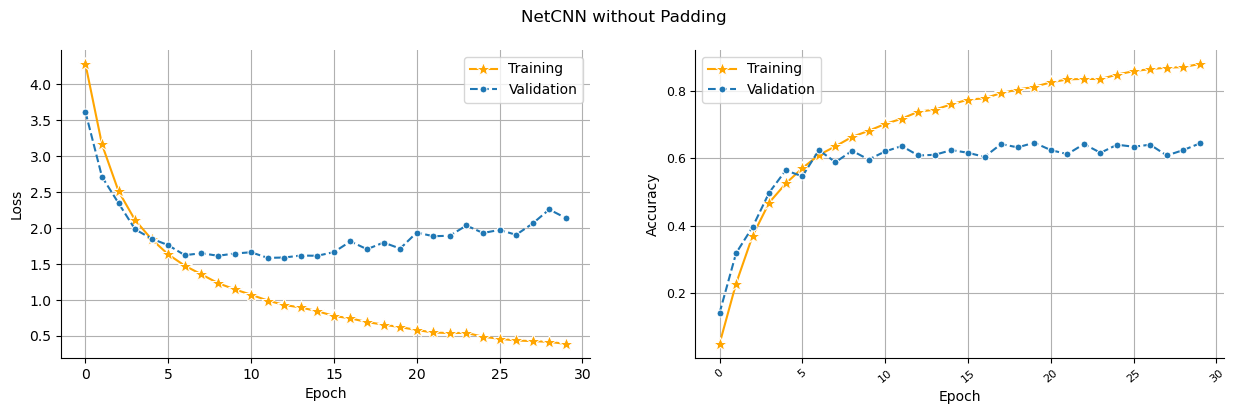

In [28]:
plot_loss_and_accuracy(experiment, title='NetCNN without Padding')

In [29]:
params = model.state_dict()

# Dimensiones de las capas
print('Dimensiones de las capas:')
for name, param in model.named_parameters():
    print(f'\t{name}: {param.shape}')

# Cantidad de parámetros
print('Cantidad de parámetros:')
for key, value in params.items():
    print(f'\t{key}: {torch.numel(value)}')

print(f'Modelo: {model}')

Dimensiones de las capas:
	conv1.weight: torch.Size([10, 3, 5, 5])
	conv1.bias: torch.Size([10])
	conv2.weight: torch.Size([20, 10, 5, 5])
	conv2.bias: torch.Size([20])
	fc.weight: torch.Size([100, 320])
	fc.bias: torch.Size([100])
Cantidad de parámetros:
	conv1.weight: 750
	conv1.bias: 10
	conv2.weight: 5000
	conv2.bias: 20
	fc.weight: 32000
	fc.bias: 100
Modelo: NetCNNwithoutPadding(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=320, out_features=100, bias=True)
)


## Entrenar NetCNN

In [30]:
num_epochs = 30
model = NetCNN()
optimizer = optim.SGD(model.parameters(), lr=1e-2, weight_decay=0.001, momentum=0.9)

experiment, all_labels, all_preds = train_val(model, criterion, optimizer, train_loader, val_loader, num_epochs)

Epoch 1/30, train loss: 4.4552, train acc: 0.0313, val loss: 4.1027, val acc: 0.0520
Epoch 2/30, train loss: 3.8201, train acc: 0.1182, val loss: 3.5406, val acc: 0.1780
Epoch 3/30, train loss: 3.1880, train acc: 0.2442, val loss: 2.9399, val acc: 0.3060
Epoch 4/30, train loss: 2.6060, train acc: 0.3646, val loss: 2.3812, val acc: 0.4400
Epoch 5/30, train loss: 2.1511, train acc: 0.4603, val loss: 2.2030, val acc: 0.4740
Epoch 6/30, train loss: 1.8547, train acc: 0.5287, val loss: 1.9738, val acc: 0.5260
Epoch 7/30, train loss: 1.6302, train acc: 0.5813, val loss: 1.9643, val acc: 0.5160
Epoch 8/30, train loss: 1.4739, train acc: 0.6143, val loss: 1.8802, val acc: 0.5540
Epoch 9/30, train loss: 1.3243, train acc: 0.6486, val loss: 1.8604, val acc: 0.5660
Epoch 10/30, train loss: 1.2238, train acc: 0.6727, val loss: 1.7906, val acc: 0.5820
Epoch 11/30, train loss: 1.1089, train acc: 0.6983, val loss: 1.8786, val acc: 0.6000
Epoch 12/30, train loss: 1.0177, train acc: 0.7238, val loss: 1

0
1


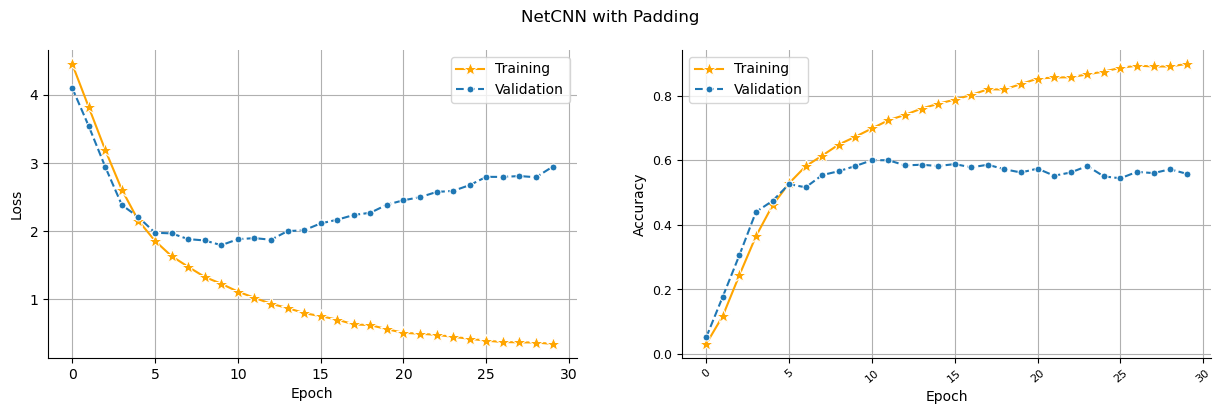

In [31]:
plot_loss_and_accuracy(experiment, title='NetCNN with Padding')

In [32]:
params = model.state_dict()

# Dimensiones de las capas
print('Dimensiones de las capas:')
for name, param in model.named_parameters():
    print(f'\t{name}: {param.shape}')

# Cantidad de parámetros
print('Cantidad de parámetros:')
for key, value in params.items():
    print(f'\t{key}: {torch.numel(value)}')

print(f'Modelo: {model}')

Dimensiones de las capas:
	conv1.weight: torch.Size([5, 3, 3, 3])
	conv1.bias: torch.Size([5])
	conv2.weight: torch.Size([10, 5, 3, 3])
	conv2.bias: torch.Size([10])
	fc.weight: torch.Size([100, 490])
	fc.bias: torch.Size([100])
Cantidad de parámetros:
	conv1.weight: 135
	conv1.bias: 5
	conv2.weight: 450
	conv2.bias: 10
	fc.weight: 49000
	fc.bias: 100
Modelo: NetCNN(
  (conv1): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(5, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=490, out_features=100, bias=True)
)


## Modificar el modelo

In [33]:
# Change the number of out channels
model = NetCNN()

model.conv1 = nn.Conv2d(in_channels=3, out_channels=4, kernel_size=5, padding=0)
model.conv2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, padding=0)
model.fc = nn.Linear(5 * 5 * 8, 100)

optimizer = optim.SGD(model.parameters(), lr=1e-2, weight_decay=0.001, momentum=0.9)

experiment, all_labels, all_preds = train_val(model, criterion, optimizer, train_loader, val_loader, 30)

Epoch 1/30, train loss: 4.3917, train acc: 0.0363, val loss: 3.9025, val acc: 0.0940
Epoch 2/30, train loss: 3.4096, train acc: 0.1942, val loss: 2.9097, val acc: 0.2900
Epoch 3/30, train loss: 2.7834, train acc: 0.3231, val loss: 2.5430, val acc: 0.3720
Epoch 4/30, train loss: 2.4258, train acc: 0.3995, val loss: 2.3013, val acc: 0.4460
Epoch 5/30, train loss: 2.1895, train acc: 0.4497, val loss: 2.1775, val acc: 0.4600
Epoch 6/30, train loss: 2.0305, train acc: 0.4908, val loss: 2.0166, val acc: 0.5000
Epoch 7/30, train loss: 1.9124, train acc: 0.5163, val loss: 2.0249, val acc: 0.4820
Epoch 8/30, train loss: 1.7958, train acc: 0.5392, val loss: 1.9248, val acc: 0.4900
Epoch 9/30, train loss: 1.7253, train acc: 0.5557, val loss: 1.9528, val acc: 0.5240
Epoch 10/30, train loss: 1.6667, train acc: 0.5667, val loss: 1.9124, val acc: 0.5340
Epoch 11/30, train loss: 1.6046, train acc: 0.5786, val loss: 1.9298, val acc: 0.5260
Epoch 12/30, train loss: 1.5534, train acc: 0.5894, val loss: 1

0
1


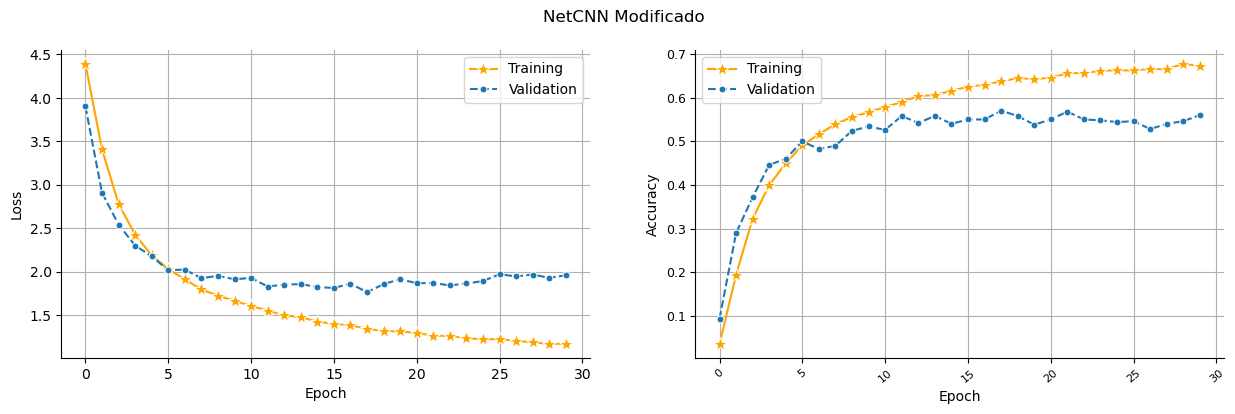

In [34]:
plot_loss_and_accuracy(experiment, title='NetCNN Modificado')

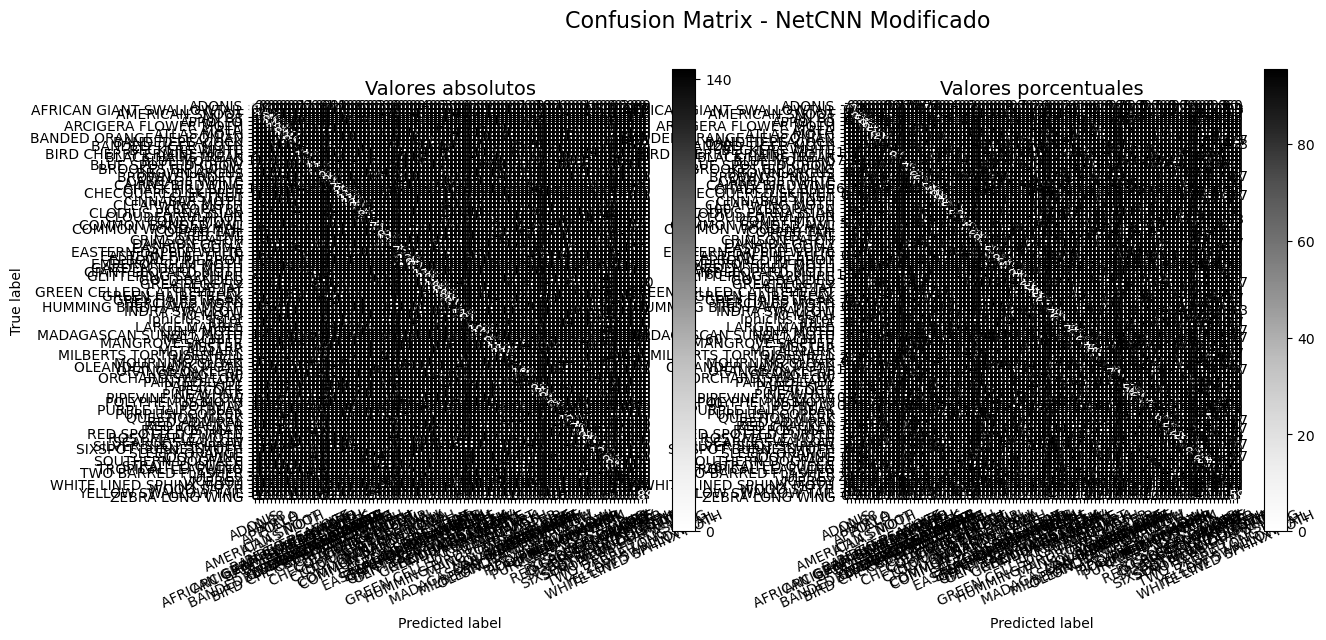

In [37]:
plotting_confusion_matrix(all_labels, all_preds, title_name='- NetCNN Modificado')

In [38]:
# Otra manera de cambiar los parámetros de la red
setattr(model, 'conv1', nn.Conv2d(in_channels=3, out_channels=4, kernel_size=5, padding=0))
setattr(model, 'conv2', nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, padding=0))
setattr(model, 'fc', nn.Linear(5 * 5 * 8, 100))
print(f'Modelo: {model}')

Modelo: NetCNN(
  (conv1): Conv2d(3, 4, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=200, out_features=100, bias=True)
)


## Ejemplo de Otra Arquitectura con Batch Normalization

### 🤷 **¿Aplicar batch normalization antes o después del pooling?** 🤯

In [39]:
# Model with batch normalization applied after pooling
class NetCNNwithBN_v1(nn.Module):
    def __init__(self):
        super(NetCNNwithBN_v1, self).__init__()

        # Implement the sequential module for feature extraction
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(10),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(20),
            nn.ReLU(inplace=True),
            )

        # Implement the fully connected layer for classification
        self.fc = nn.Linear(in_features=7 * 7 * 20, out_features=100)

    def forward(self, x):

        # Apply the feature extractor in the input
        x = self.features(x)

        # Squeeze the three spatial dimensions in one
        x = x.view(-1, self.fc.in_features)

        # Classify the images
        x = self.fc(x)
        return x

In [40]:
# Entrenamiento con optimizador Adam
model = NetCNNwithBN_v1()
optimizer = optim.SGD(model.parameters(), lr=1e-2, weight_decay=0.001, momentum=0.9)
experiment, all_labels, all_preds = train_val(model, criterion, optimizer, train_loader, val_loader, num_epochs)

Epoch 1/30, train loss: 3.1542, train acc: 0.2716, val loss: 2.0867, val acc: 0.5120
Epoch 2/30, train loss: 1.7902, train acc: 0.5450, val loss: 1.5817, val acc: 0.6140
Epoch 3/30, train loss: 1.3125, train acc: 0.6568, val loss: 1.5052, val acc: 0.6180
Epoch 4/30, train loss: 1.0258, train acc: 0.7298, val loss: 1.4211, val acc: 0.6580
Epoch 5/30, train loss: 0.8065, train acc: 0.7841, val loss: 1.4081, val acc: 0.6500
Epoch 6/30, train loss: 0.6273, train acc: 0.8346, val loss: 1.3823, val acc: 0.6700
Epoch 7/30, train loss: 0.5011, train acc: 0.8695, val loss: 1.3726, val acc: 0.6760
Epoch 8/30, train loss: 0.3840, train acc: 0.9034, val loss: 1.3728, val acc: 0.6960
Epoch 9/30, train loss: 0.2880, train acc: 0.9343, val loss: 1.4593, val acc: 0.6800
Epoch 10/30, train loss: 0.2176, train acc: 0.9555, val loss: 1.3694, val acc: 0.6880
Epoch 11/30, train loss: 0.1748, train acc: 0.9673, val loss: 1.4118, val acc: 0.6680
Epoch 12/30, train loss: 0.1349, train acc: 0.9798, val loss: 1

0
1


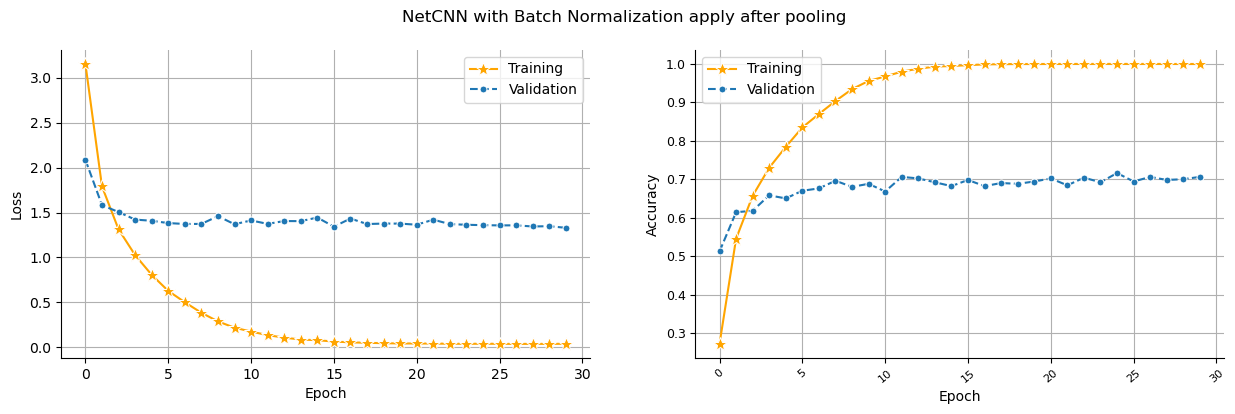

In [41]:
plot_loss_and_accuracy(experiment, title='NetCNN with Batch Normalization apply after pooling')

In [42]:
# Model with batch normalization applied before pooling
class NetCNNwithBN_v2(nn.Module):
    def __init__(self):
        super(NetCNNwithBN_v2, self).__init__()

        # Implement the sequential module for feature extraction
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(10),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(20),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )

        # Implement the fully connected layer for classification
        self.fc = nn.Linear(in_features=7 * 7 * 20, out_features=100)

    def forward(self, x):

        # Apply the feature extractor in the input
        x = self.features(x)

        # Squeeze the three spatial dimensions in one
        x = x.view(-1, self.fc.in_features)

        # Classify the images
        x = self.fc(x)
        return x

In [43]:
# Entrenamiento con optimizador SGD con momentum
model = NetCNNwithBN_v2()
optimizer = optim.SGD(model.parameters(), lr=1e-2, weight_decay=0.001, momentum=0.9)
experiment, all_labels, all_preds = train_val(model, criterion, optimizer, train_loader, val_loader, num_epochs)

Epoch 1/30, train loss: 3.1004, train acc: 0.2697, val loss: 2.1909, val acc: 0.4420
Epoch 2/30, train loss: 1.8727, train acc: 0.5212, val loss: 1.7364, val acc: 0.5800
Epoch 3/30, train loss: 1.4304, train acc: 0.6252, val loss: 1.7178, val acc: 0.5800
Epoch 4/30, train loss: 1.1812, train acc: 0.6878, val loss: 1.5854, val acc: 0.6100
Epoch 5/30, train loss: 0.9682, train acc: 0.7397, val loss: 1.5496, val acc: 0.6020
Epoch 6/30, train loss: 0.7987, train acc: 0.7770, val loss: 1.4246, val acc: 0.6840
Epoch 7/30, train loss: 0.6712, train acc: 0.8105, val loss: 1.4737, val acc: 0.6520
Epoch 8/30, train loss: 0.5448, train acc: 0.8501, val loss: 1.5556, val acc: 0.6240
Epoch 9/30, train loss: 0.4584, train acc: 0.8730, val loss: 1.5175, val acc: 0.6640
Epoch 10/30, train loss: 0.3875, train acc: 0.8931, val loss: 1.5924, val acc: 0.6700
Epoch 11/30, train loss: 0.3213, train acc: 0.9177, val loss: 1.4971, val acc: 0.6820
Epoch 12/30, train loss: 0.2633, train acc: 0.9325, val loss: 1

0
1


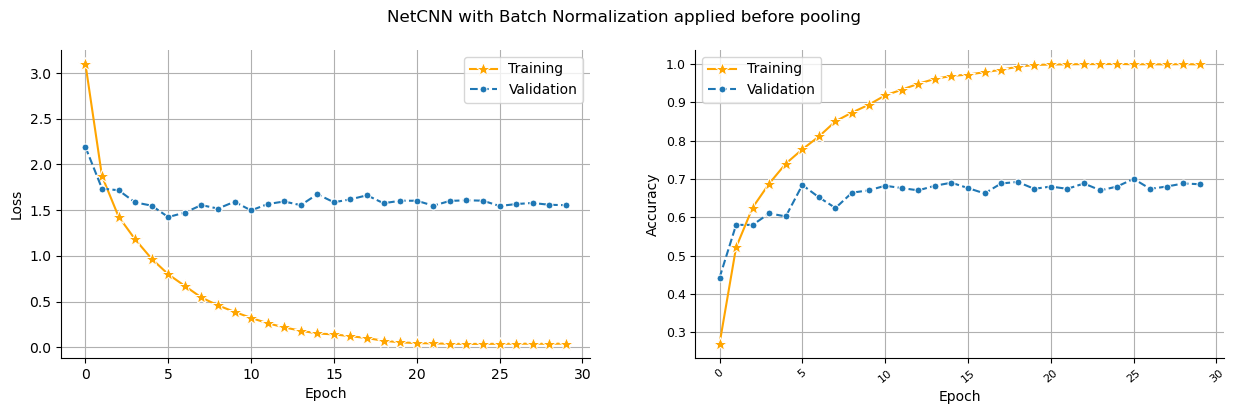

In [44]:
plot_loss_and_accuracy(experiment, title='NetCNN with Batch Normalization applied before pooling')

**¿Aplicar batch normalization antes o después de la función de activación?**

Se sugiere:
- Con función de activación ReLU --> aplicar antes
- Con función de activación sigmoides (tanh y logística) --> aplicar después

En general, funciona mejor aplicar batch normalization antes de la función de activación.

Sin embargo, siempre es bueno probar ambos ordenes para ver qué funciona mejor.

In [ ]:
# Probar aplicar batch normalization después de la activación ReLU (Concluir)




## Transfer Learning

### Transfer Learning [Resnet18](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html)

In [59]:
batch_size = 64

# Transformar los datos en tensores y normalícelos
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# transform = transforms.Compose([transforms.ToTensor()])
transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# Preparar el conjunto de entrenamiento y el conjunto de validación
#trainset = datasets.CIFAR10('.', download=True, train=True, transform=transform)
#validateset = datasets.CIFAR10('.', download=False, train=False, transform=transform)

# Construir el cargador de entranamiento
#train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True,)

# Construir el cargador de validación
#val_loader = DataLoader(validateset, batch_size=batch_size, shuffle=False,)

In [60]:
train_set, train_loader, val_set, val_loader, test_set, test_loader = data_preparation(batch_size, transform)

In [61]:
# Cargar el modelo preentrenado
model_rn18 = torchvision.models.resnet18(pretrained=True)
print(f'Modelo: {model_rn18}')

Modelo: ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=

In [62]:
# Explorar las capas del modelo
for i, w in enumerate(model_rn18.parameters()):
    print(i+1, w.shape, w.requires_grad)

1 torch.Size([64, 3, 7, 7]) True
2 torch.Size([64]) True
3 torch.Size([64]) True
4 torch.Size([64, 64, 3, 3]) True
5 torch.Size([64]) True
6 torch.Size([64]) True
7 torch.Size([64, 64, 3, 3]) True
8 torch.Size([64]) True
9 torch.Size([64]) True
10 torch.Size([64, 64, 3, 3]) True
11 torch.Size([64]) True
12 torch.Size([64]) True
13 torch.Size([64, 64, 3, 3]) True
14 torch.Size([64]) True
15 torch.Size([64]) True
16 torch.Size([128, 64, 3, 3]) True
17 torch.Size([128]) True
18 torch.Size([128]) True
19 torch.Size([128, 128, 3, 3]) True
20 torch.Size([128]) True
21 torch.Size([128]) True
22 torch.Size([128, 64, 1, 1]) True
23 torch.Size([128]) True
24 torch.Size([128]) True
25 torch.Size([128, 128, 3, 3]) True
26 torch.Size([128]) True
27 torch.Size([128]) True
28 torch.Size([128, 128, 3, 3]) True
29 torch.Size([128]) True
30 torch.Size([128]) True
31 torch.Size([256, 128, 3, 3]) True
32 torch.Size([256]) True
33 torch.Size([256]) True
34 torch.Size([256, 256, 3, 3]) True
35 torch.Size([2

In [63]:
# Una muestra de lo que hace anteponer un * a una lista
lista_demo = ['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool', 'fc']
print(lista_demo, end='\n\n')
print(*lista_demo)

['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool', 'fc']

conv1 bn1 relu maxpool layer1 layer2 layer3 layer4 avgpool fc


In [64]:
# Seleccionar las capas que no se van a entrenar
# model_fit_rn18 = nn.Sequential(*list(model_rn18.children()))  # Selecciona todas las capas
model_fit_rn18 = nn.Sequential(*list(model_rn18.children())[:-1])  # Selecciona todas las capas excepto la última
model_fit_rn18

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [68]:
# Congelar todas las capas excepto la última, para que no se entrenen
for param in model_fit_rn18.parameters():
    param.requires_grad = False

# Agregar la capa de salida ajustada a nuestra salida y entrenar
model_fitted_resnet18 = nn.Sequential(
                            model_fit_rn18,
                            nn.Flatten(),   # aplana la salida obtenida de la capa anterior
                            # el valor 512 es el número de canales de la última capa convolucional
                            nn.Linear(in_features=512, out_features=100, bias=True))
model_fitted_resnet18

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [66]:
# Explorar las capas del modelo
for i, w in enumerate(model_fitted_resnet18.parameters()):
    print(i+1, w.shape, w.requires_grad)

1 torch.Size([64, 3, 7, 7]) False
2 torch.Size([64]) False
3 torch.Size([64]) False
4 torch.Size([64, 64, 3, 3]) False
5 torch.Size([64]) False
6 torch.Size([64]) False
7 torch.Size([64, 64, 3, 3]) False
8 torch.Size([64]) False
9 torch.Size([64]) False
10 torch.Size([64, 64, 3, 3]) False
11 torch.Size([64]) False
12 torch.Size([64]) False
13 torch.Size([64, 64, 3, 3]) False
14 torch.Size([64]) False
15 torch.Size([64]) False
16 torch.Size([128, 64, 3, 3]) False
17 torch.Size([128]) False
18 torch.Size([128]) False
19 torch.Size([128, 128, 3, 3]) False
20 torch.Size([128]) False
21 torch.Size([128]) False
22 torch.Size([128, 64, 1, 1]) False
23 torch.Size([128]) False
24 torch.Size([128]) False
25 torch.Size([128, 128, 3, 3]) False
26 torch.Size([128]) False
27 torch.Size([128]) False
28 torch.Size([128, 128, 3, 3]) False
29 torch.Size([128]) False
30 torch.Size([128]) False
31 torch.Size([256, 128, 3, 3]) False
32 torch.Size([256]) False
33 torch.Size([256]) False
34 torch.Size([256, 

In [69]:
# Entrenar la última capa del modelo
num_epochs = 20
model_tl = model_fitted_resnet18
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad,
                                   model_tl.parameters()),
                            lr=0.001, momentum=0.9)
# optimizer = torch.optim.SGD(model_tl.parameters(), lr=1e-4, betas=(0.9, 0.999))
# optimizer = torch.optim.Adam(model_tl.parameters(), lr=1e-2, weight_decay=0.001)
experiment, all_labels, all_preds = train_val(model_tl, criterion,
                                              optimizer, train_loader, val_loader, num_epochs)

Epoch 1/20, train loss: 4.1378, train acc: 0.1558, val loss: 3.4753, val acc: 0.4000
Epoch 2/20, train loss: 3.0300, train acc: 0.5389, val loss: 2.5060, val acc: 0.6600
Epoch 3/20, train loss: 2.2734, train acc: 0.7148, val loss: 1.9058, val acc: 0.7360
Epoch 4/20, train loss: 1.7962, train acc: 0.7770, val loss: 1.5263, val acc: 0.7880
Epoch 5/20, train loss: 1.4861, train acc: 0.8103, val loss: 1.2812, val acc: 0.8320
Epoch 6/20, train loss: 1.2726, train acc: 0.8374, val loss: 1.1148, val acc: 0.8440
Epoch 7/20, train loss: 1.1248, train acc: 0.8494, val loss: 0.9883, val acc: 0.8440
Epoch 8/20, train loss: 1.0136, train acc: 0.8593, val loss: 0.9055, val acc: 0.8600
Epoch 9/20, train loss: 0.9276, train acc: 0.8649, val loss: 0.8361, val acc: 0.8640
Epoch 10/20, train loss: 0.8590, train acc: 0.8709, val loss: 0.7848, val acc: 0.8720
Epoch 11/20, train loss: 0.8035, train acc: 0.8757, val loss: 0.7402, val acc: 0.8800
Epoch 12/20, train loss: 0.7554, train acc: 0.8818, val loss: 0

In [71]:
PATH = './cnn_resnet18.pth'
torch.save(model_tl.state_dict(), PATH)

0
1


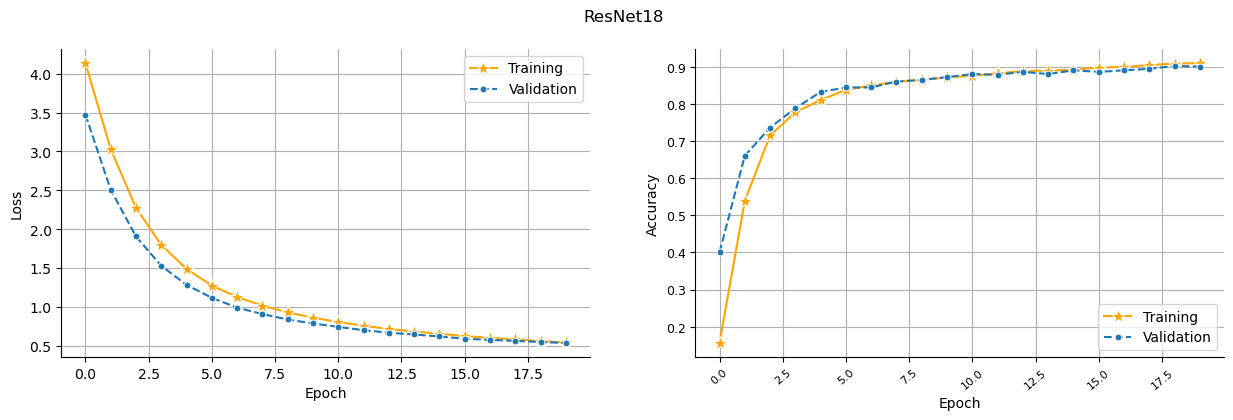

In [72]:
plot_loss_and_accuracy(experiment, title='ResNet18')

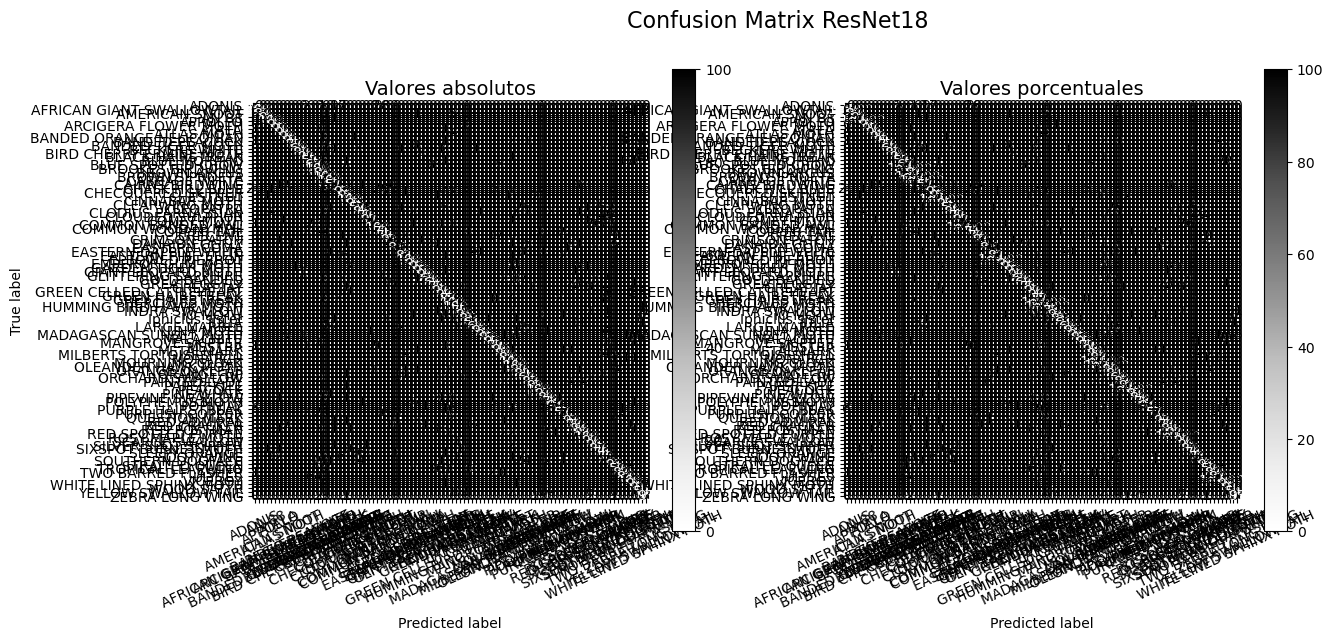

In [73]:
plotting_confusion_matrix(all_labels, all_preds, title_name='ResNet18')

### Transfer Learning [VGG16](https://pytorch.org/vision/stable/models/generated/torchvision.models.vgg16.html)

In [74]:
# Exploremos otro modelo
model_fit_vgg16 = torchvision.models.vgg16()
model_fit_vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [75]:
# Veamos el grupos de capas clasificadoras
model_fit_vgg16.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [76]:
# Veamos la última capa clasificadora
model_fit_vgg16.classifier[6]

Linear(in_features=4096, out_features=1000, bias=True)

In [77]:
model_tl = model_fit_vgg16
# Modifiquemos algunas capas clasificadoras para reentrenarla con los datos y poder hacer la clasificación de 10 clases
for param in model_tl.parameters():
    param.requires_grad = False

n_clases = 100
model_tl.classifier[3].requires_grad = True
model_tl.classifier[3] = nn.Linear(4096, 1024)
model_tl.classifier[6].requires_grad = True
model_tl.classifier[6] = nn.Linear(1024, n_clases)
model_tl.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=1024, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=1024, out_features=100, bias=True)
)

In [78]:
# Explorar las capas del modelo
for i, w in enumerate(model_tl.parameters()):
    print(i, w.shape, w.requires_grad)

0 torch.Size([64, 3, 3, 3]) False
1 torch.Size([64]) False
2 torch.Size([64, 64, 3, 3]) False
3 torch.Size([64]) False
4 torch.Size([128, 64, 3, 3]) False
5 torch.Size([128]) False
6 torch.Size([128, 128, 3, 3]) False
7 torch.Size([128]) False
8 torch.Size([256, 128, 3, 3]) False
9 torch.Size([256]) False
10 torch.Size([256, 256, 3, 3]) False
11 torch.Size([256]) False
12 torch.Size([256, 256, 3, 3]) False
13 torch.Size([256]) False
14 torch.Size([512, 256, 3, 3]) False
15 torch.Size([512]) False
16 torch.Size([512, 512, 3, 3]) False
17 torch.Size([512]) False
18 torch.Size([512, 512, 3, 3]) False
19 torch.Size([512]) False
20 torch.Size([512, 512, 3, 3]) False
21 torch.Size([512]) False
22 torch.Size([512, 512, 3, 3]) False
23 torch.Size([512]) False
24 torch.Size([512, 512, 3, 3]) False
25 torch.Size([512]) False
26 torch.Size([4096, 25088]) False
27 torch.Size([4096]) False
28 torch.Size([1024, 4096]) True
29 torch.Size([1024]) True
30 torch.Size([100, 1024]) True
31 torch.Size([100

In [79]:
num_epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad,
                                   model_tl.parameters()),
                            lr=0.001, momentum=0.9)

experiment, all_labels, all_preds = train_val(model_tl, criterion, optimizer, train_loader, val_loader, num_epochs)

KeyboardInterrupt: 

0
1


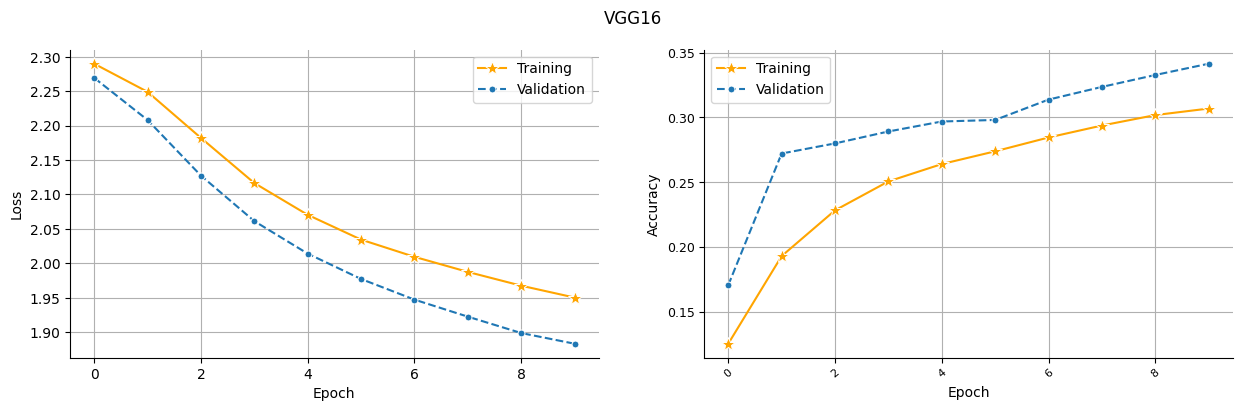

In [ ]:
plot_loss_and_accuracy(experiment, title='VGG16')

### Para jugar con el modelo

In [ ]:
# Cambiar transform de los datos
# Barajar los indices
indices = np.arange(50000)
np.random.shuffle(indices)
n_train = 45000

# Transformar los datos en tensores y normalícelos
transform = transforms.Compose([
    transforms.Resize((128, 128)), # Resize (height x width)
    transforms.ToTensor(),
    # Media y desviación estándar de imagenes image-net
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])

# Preparar el conjunto de entrenamiento y el conjunto de validación
dataset = datasets.CIFAR10('.', download=True, train=True, transform=transform)

# Construir el cargador de entranamiento
train_loader = DataLoader(dataset,
                          batch_size=64,
                          shuffle=True,
                        # shuffle=False, sampler=SubsetRandomSampler(indices[:n_train])
                            )

# Construir el cargador de validación
val_loader = DataLoader(dataset,
                            batch_size=64, shuffle=False,
                            sampler=SubsetRandomSampler(indices[n_train:])
)

Files already downloaded and verified


In [ ]:
# Modifique este grupo de capas de clasificación para reentrenar el modelo con nuestros datos
# Reentrenar la segunda capa lineal
model_tl.classifier[3].requires_grad = True
# Modificar la última y penúltima capa de clasificación para reducir el número de parámetros
model_tl.classifier[6] = nn.Sequential(
                      nn.Linear(4096, 256),
                      nn.ReLU(),
                      nn.Dropout(0.3),
                      nn.Linear(256, n_clases))

In [ ]:
model_tl.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
)